In [19]:
# Imports

import os
import json
import tqdm
import yaml

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from omegaconf import OmegaConf
from pathlib import Path
from tqdm.auto import tqdm

import lightning as L

In [20]:
%%bash
mkdir -p results
fusermount -uz results
sshfs compute.ies:/mnt/work/dhuseljic/results/uncertainty results
ls results

baselines
CIFAR10


In [21]:
def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
        
    results = {}

    exp_json = path / 'results_final.json'
    exp_cfg = path / '.hydra' / 'config.yaml'
    try:
        cfg =  OmegaConf.load(exp_cfg)
        data = load_json(exp_json)
    except:
        print(f'{path} has missing results.')
        return

    results['args'] = cfg
    # results['checkpoint'] = checkpoint
    results['results'] = data
    return results

def load_args(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    exp_cfg = path / '.hydra' / 'config.yaml'
    cfg =  OmegaConf.load(exp_cfg)
    return cfg

def load_checkpoint(path, final=True):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    if final:
        exp_pth = path / 'model_final.pth'
    else:
        exp_pth = path / 'checkpoint.pth'
    checkpoint = torch.load(exp_pth)
    return checkpoint

def get_experiments(result_path, glob_pattern, train_results=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    for exp_path in result_path.glob(glob_pattern):
        d = load_results(exp_path)
        experiments.append(d)
    assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

path = f'results/baselines/CIFAR10/resnet18/'
exp_results = get_experiments(Path(path), 'seed1')
# metrics = get_metric_values(exp_results)
print(exp_results[0]['results'].keys())
# print(len(exp_results[0]['results']['train_history']))
# print(exp_results[0]['results']['test_stats'].keys())

dict_keys(['test_stats', 'misc'])


In [22]:
# Baseline results
dataset = 'CIFAR10'
experiments = {}
experiments.update({
    'standard': f'results/baselines/CIFAR10/resnet18/',
    'label_smoothing': f'results/baselines/CIFAR10/resnet18_labelsmoothing/',
    'mixup': f'results/baselines/CIFAR10/resnet18_mixup/',
    'sngp': f'results/baselines/CIFAR10/resnet18_sngp/',
})


all_results = {}
for exp_name, exp_path in tqdm(experiments.items()):
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed1')


100%|██████████| 4/4 [00:00<00:00, 20.88it/s]


In [23]:
result_dict = {}

for exp_name in experiments:
    d = {}
    for metric_key in ['accuracy', 'brier', 'ece', 'ace', 'auroc_SVHN', 'auroc_CIFAR100']: 
        vals = [seed_results['results']['test_stats'][metric_key] for seed_results in all_results[exp_name]]
        d[metric_key] = np.mean(vals)
    result_dict[exp_name] = d
print(pd.DataFrame(result_dict).T.to_markdown())

|                 |   accuracy |     brier |       ece |       ace |   auroc_SVHN |   auroc_CIFAR100 |
|:----------------|-----------:|----------:|----------:|----------:|-------------:|-----------------:|
| standard        |     0.9487 | 0.0818726 | 0.0284268 | 0.0325498 |     0.932051 |         0.875797 |
| label_smoothing |     0.9504 | 0.0766043 | 0.0421233 | 0.0344024 |     0.828632 |         0.817661 |
| mixup           |     0.9553 | 0.0723285 | 0.0595207 | 0.0274186 |     0.905869 |         0.838182 |
| sngp            |     0.9447 | 0.0847735 | 0.0052315 | 0.0140459 |     0.958704 |         0.882381 |


In [24]:
import sys
sys.path.append('..')
from uncertainty import build_model, build_dataset

path = f'results/baselines/CIFAR10/resnet18/seed1'
args = load_args(path)
args.num_devices = 1
args.dataset_path = '/datasets'
checkpoint = load_checkpoint(path)

_, test_dataset, ds_info = build_dataset(args)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
model, trainer = build_model(args, n_classes=ds_info['n_classes'])
model.load_state_dict(checkpoint['model'])

args

Files already downloaded and verified
Files already downloaded and verified


{'dataset': 'CIFAR10', 'dataset_path': '/datasets', 'ood_datasets': ['SVHN', 'CIFAR100'], 'num_samples': None, 'eval_interval': 50, 'test_batch_size': 64, 'random_seed': 1, 'device': 'cuda', 'num_devices': 1, 'output_dir': '/mnt/work/dhuseljic/results/uncertainty/baselines/CIFAR10/resnet18/seed1', 'model': {'name': 'resnet18_deterministic', 'n_epochs': 200, 'batch_size': 64, 'optimizer': {'lr': 0.1, 'weight_decay': 0.0005, 'momentum': 0.9}}}

In [25]:
logits, targets = trainer.predict(test_loader)

In [26]:
from dal_toolbox.metrics import Accuracy, TopLabelCalibrationError, ExpectedCalibrationError, MarginalCalibrationError

acc_fn = Accuracy()
tce_fn = TopLabelCalibrationError()
print('Accuracy:', acc_fn(logits, targets).item())
# print('ECE:', ExpectedCalibrationError()(logits.softmax(-1), targets).item())
print('ECE:', tce_fn(logits.softmax(-1), targets).item())
print('MCE:', MarginalCalibrationError()(logits.softmax(-1), targets).item())

Accuracy: 0.9508000016212463
ECE: 0.02638227492570877
MCE: 0.038626622408628464


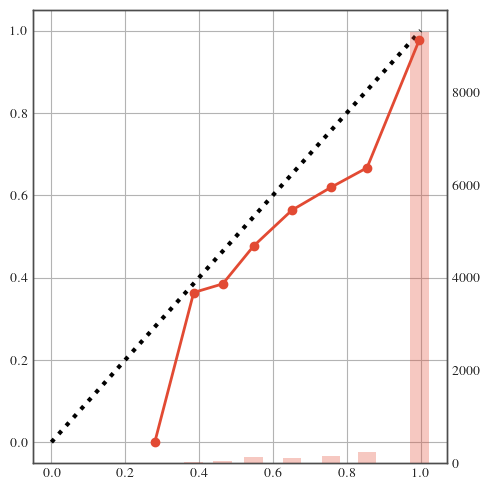

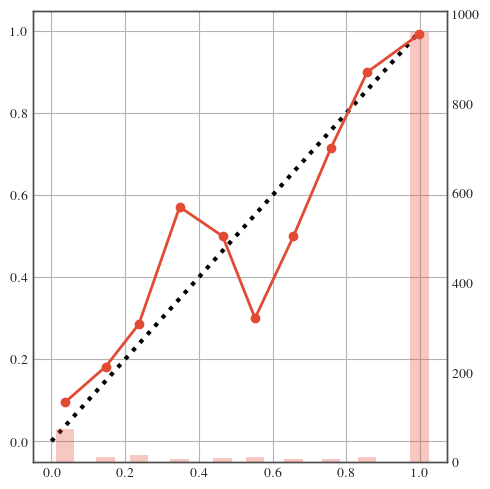

In [28]:
from dal_toolbox.metrics import TopLabelCalibrationPlot, MarginalCalibrationPlot
from dal_toolbox.utils import plot_tcp, plot_mcp

tcp_results = TopLabelCalibrationPlot(num_bins=10)(logits.softmax(-1), targets)

plt.figure(figsize=(5, 5))
plot_tcp(tcp_results)
plt.tight_layout()
plt.show()

mcp_results = MarginalCalibrationPlot(num_bins=10)(logits.softmax(-1), targets)
plt.figure(figsize=(5, 5))
plot_mcp(mcp_results, classes=1, plot_bars=True)
plt.tight_layout()
plt.show()